# Movie Recommendations

Recommendations are a common machine learning task widely used by many leading companies, such as Netflix, Amazon, and YouTube. If you have used any of these online services, you are familiar with recommendations that are often prefixed with "You might also like.." or "Recommended items other customers buy...".

There are many ways to generate recommendations. It could be done based on simple criteria, such as movie genre, e.g. comedies or action adventure. More sophisticated recommendations might consider many more factors, such as the director, when the movie was produced and so on.

In this example, we will use a common, straightforward method known as [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering). This method is based on idea that many customers have similar likes and dislikes. It also considers similarities between products. It's a simple, yet effective technique that depends only user preferences, such as product ratings. If you have a sufficiently large dataset of ratings from your customers, then this approach is a good place to start.

In [0]:
%tensorflow_version 1.x

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Add, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Load data

In this example, we will make movie recommendations given about 100,000 samples from roughly 10,000 customers or users.

The data set is freely available on the [MovieLens website](https://grouplens.org/datasets/movielens/).

In [17]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2019-12-15 16:10:38--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   972KB/s    in 1.0s    

2019-12-15 16:10:40 (972 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [18]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [19]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Join Ratings with Movies

The ratings don't contain movie titles, so let's join or merge these two sets for convenience.

In [21]:
ratings = ratings.merge(movies, on='movieId').drop(['genres','timestamp'],axis=1)
ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


## Generate Sequential Identifiers

`userId` and `movieId` are not sequential, which causes problems for our model. To compensate, we can use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) class from [scikit-learn](https://scikit-learn.org/) to generate sequential identifiers for users and movies. The original identifiers are still available, so we can always join back to the original data set if needed.

In [22]:
user_enc = LabelEncoder()
ratings['userSeq'] = user_enc.fit_transform(ratings['userId'].values)

item_enc = LabelEncoder()
ratings['movieSeq'] = item_enc.fit_transform(ratings['movieId'].values)

ratings.head()

,userId,movieId,rating,title,userSeq,movieSeq
0,1,1,4.0,Toy Story (1995),0,0
1,5,1,4.0,Toy Story (1995),4,0
2,7,1,4.5,Toy Story (1995),6,0
3,15,1,2.5,Toy Story (1995),14,0
4,17,1,4.5,Toy Story (1995),16,0


## Train/Test Split

This case is a bit unusual because we need ratings for every movie from every user to train an accurate model. If we used a traditional split, some movies might be left out, which will cause problems during prediction.

For this reason, we will use all of the data for training and a subset for model validation only.

In [23]:
train_unused, test = train_test_split(ratings, test_size=0.20, random_state=0)

# All data is used for training
train = ratings

numUsers = len(train.userSeq.unique())
numMovies = len(train.movieSeq.unique())
print((numUsers, numMovies))
print((len(train), len(test)))

(610, 9724)
(100836, 20168)


## Recommendation Model

Collaborative filtering tries to minimize the error between a predicted value and ground truth. This is similar to many supervised machine learning problems. The model learns a set of features that similar movies share. The number of features could be as simple as the genre or more complex. The `numFeatures` variable below is a hyperparameter that can be tuned to optimize performance.

This model uses the [Keras functional API](https://keras.io/getting-started/functional-api-guide/) rather than adding layers to a Sequential model. This is necessary because we have two sets of inputs, userSeq and movieSeq.

In [24]:
numFeatures = 50
dropout = 0.0

user_input = Input(shape=(1,))
user_emb = Embedding(numUsers, numFeatures)(user_input)
flat_user = Flatten()(user_emb)
user_dropout = Dropout(dropout)(flat_user)

movie_input = Input(shape=(1,))
movie_emb = Embedding(numMovies, numFeatures)(movie_input)
flat_movie = Flatten()(movie_emb)
movie_dropout = Dropout(dropout)(flat_movie)

dotProduct = Dot(axes=1)([user_dropout, movie_dropout])

user_bias = Embedding(numUsers, 1)(user_input)
movie_bias = Embedding(numMovies, 1)(movie_input)
sum = Add()([dotProduct, user_bias, movie_bias])
flat_sum = Flatten()(sum)
output = Dropout(dropout)(flat_sum)

model = Model([user_input, movie_input], output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        30500       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 50)        486200      input_4[0][0]                    
____________________________________________________________________________________________

## Model Training

Train on 100836 samples, validate on 20168 samples
Epoch 1/10
100836/100836 [==============================] - 16s 164us/step - loss: 6.2500 - val_loss: 1.4570
Epoch 2/10
100836/100836 [==============================] - 16s 161us/step - loss: 1.1482 - val_loss: 0.7989
Epoch 3/10
100836/100836 [==============================] - 16s 162us/step - loss: 0.8057 - val_loss: 0.6416
Epoch 4/10
100836/100836 [==============================] - 16s 161us/step - loss: 0.6685 - val_loss: 0.5376
Epoch 5/10
100836/100836 [==============================] - 16s 159us/step - loss: 0.5638 - val_loss: 0.4538
Epoch 6/10
100836/100836 [==============================] - 16s 156us/step - loss: 0.4757 - val_loss: 0.3703
Epoch 7/10
100836/100836 [==============================] - 16s 159us/step - loss: 0.3955 - val_loss: 0.3055
Epoch 8/10
100836/100836 [==============================] - 16s 158us/step - loss: 0.3249 - val_loss: 0.2456
Epoch 9/10
100836/100836 [==============================] - 16s 158us/step - 

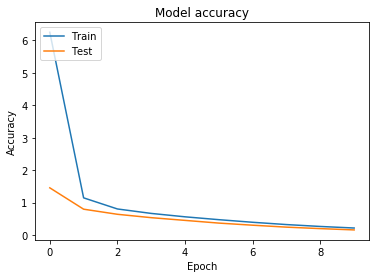

In [25]:
model.compile(loss='mean_squared_error', optimizer=Adam())
history = model.fit([train.userSeq, train.movieSeq], train.rating,
                    batch_size=32, epochs=10, verbose=1,
                    validation_data=([test.userSeq, test.movieSeq], test.rating))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Notice the validation loss is slightly lower than the training loss. If the model was overfitting, then the opposite would be true, so this is a peculiar case.

There are a few reasons this can happen:


1.   Keras artifact explained the [Keras FAQ](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss). Keras computes training loss as the average during training time, which can change quite a bit during one epoch. Validation is computed at the end of an epoch when the model loss is probably lower.
2.   The test set is not not representative of the training set. In some cases, the test set might be easier to predict than the training set. This could happen if a very small test set is used.






## Make Predictions

We can make predictions for a given user by creating a numpy array of all movies and a numpy array of the same dimension filled with just the one user we are interested in. The model will predict ratings for the specified user given all movies in the full data set.

We can then sort the data set by predicted rating descending to get the best recommendations first.

In [26]:
# The user for whom we want to make recommendations
userNumber = 0

uniqueMovies = ratings.drop_duplicates(subset=['movieSeq'])

movie_vector = uniqueMovies.movieSeq.values
user_vector = np.ones((len(uniqueMovies),)) * userNumber
predictions = model.predict([user_vector, movie_vector])
pSeries = pd.Series([a[0] for a in predictions])
predictedDF = uniqueMovies.copy()
predictedDF['Predictions'] = pSeries

predictedDF.sort_values(by='Predictions', ascending=False).head(10)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions
5770,1,1025,5.0,"Sword in the Stone, The (1963)",0,783,6.115493
4121,1,592,4.0,Batman (1989),0,509,5.881814
2755,1,362,5.0,"Jungle Book, The (1994)",0,320,5.406270
6347,1,1090,4.0,Platoon (1986),0,828,5.404517
1135,1,157,5.0,Canadian Bacon (1995),0,130,5.352393
6127,1,1080,5.0,Monty Python's Life of Brian (1979),0,819,5.003765
1146,1,163,5.0,Desperado (1995),0,136,4.963420
4992,1,661,5.0,James and the Giant Peach (1996),0,551,4.879146
2316,1,349,4.0,Clear and Present Danger (1994),0,307,4.839455
4830,1,648,3.0,Mission: Impossible (1996),0,546,4.812306


## Error Analysis

Let's look at some movies where the ground truth did not compare well with predictions.

In [27]:
oneUser = predictedDF[predictedDF.userSeq == userNumber].copy()
oneUser['Error'] = (oneUser.rating - oneUser.Predictions)**2
oneUser.sort_values(by='Error', ascending=False).head(5)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions,Error
6641,1,1136,5.0,Monty Python and the Holy Grail (1975),0,862,1.335920,13.425485
7130,1,1198,5.0,Raiders of the Lost Ark (Indiana Jones and the...,0,899,1.343206,13.372139
6216,1,1089,5.0,Reservoir Dogs (1992),0,827,1.429206,12.750567
4649,1,608,5.0,Fargo (1996),0,520,1.565738,11.794154
8450,1,1256,5.0,Duck Soup (1933),0,954,1.569469,11.768541


In [28]:
ratings[ratings.movieSeq == 520].sort_values(by='rating', ascending=True)

,userId,movieId,rating,title,userSeq,movieSeq
4827,607,608,2.0,Fargo (1996),606,520
4672,78,608,2.0,Fargo (1996),77,520
4810,546,608,2.0,Fargo (1996),545,520
4669,71,608,2.0,Fargo (1996),70,520
4812,554,608,2.0,Fargo (1996),553,520
...,...,...,...,...,...,...
4725,251,608,5.0,Fargo (1996),250,520
4718,221,608,5.0,Fargo (1996),220,520
4717,220,608,5.0,Fargo (1996),219,520
4754,324,608,5.0,Fargo (1996),323,520
